# Code to identify cut, scale and offset factors to splice curves
M.R. Fitzsimmons (July 16, 2020)

Version 1.0

This code requires some care on the part of the user. It's intended to estimate scale factors that make overlapping
Q regions have the same reflectivities.  There's is no accounting for Q-offsets arising from two theta (scattering angle) errors. The 
user has options to closely explore overlap regions, cut Q-points from end and beginning of run-pairs. The routine
will apply a scale factor that is a waited average of Q-points in common between the run-pairs. Errors on the
reflectivities are scaled as well. The individual scaled files are written with an '_red' label.  These can be
loaded into GenX as separate instruments and the scale factors and two theta offsets optimally calculated.  Finally,
a concatonated Q-sorted file is also written which has all the data (in one file).

Weighted averages of the overlapping regions are used to estimate the scale factors.

All negative reflectivities are replaced with the smallest positive reflectivity and the error for those replacements
is set equal to 1, so that in a refinement they do not influence the fitting.

# Import libraries, physical constants, and define functions. 

In [48]:
import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from itertools import cycle
import numpy as np
import scipy.optimize
from scipy.optimize import curve_fit
import scipy.constants 
import copy

# get physical constants from scipy library
Pi = scipy.constants.pi
hbar = scipy.constants.hbar
m_n = scipy.constants.neutron_mass
mu_n = np.abs(scipy.constants.physical_constants['neutron mag. mom.'][0]) # absolute value of the neutron magnetic moment J/T

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx

# function used to find location (b) of a Gaussian shaped peak sitting on a linear background.
def gaussian_and_line(x, a, b, c, d, e):
    return a*np.exp(-0.5*((x-b)/c)**2) + d + e*x


/Users/mf3
Current working directory: /Users/mf3


# Get the data
USER INPUT NEEDED

This code should not be run as 'run all cells' unless the batch toggle is set True. This is because one cell is a user test cell that should not be run except for inspection purposes.

In [49]:
# Further into the code is a "user test block" that can be repeated by the user to 
# tweak the number of cut points on the tail and head of two files.
batch_toggle = True # will skip the user test block if run as a batch job

#batch_toggle = False # will skip the user test block if run as a batch job

run_numbers = ['34669','34670','34671']

# big cut is an array of qpoints to be cut from beginning and end of each file.
# these cuts are made at the end, and generally require the user to interate cells 3-5 a few times to get right
# the number of pairs should equal the number of files above.

big_cut = [[24,7], [14,5], [6,2]] # USER INPUT here

directory_path = cwd_path+r'/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/reflectometry-analysis/' # USER INPUT HERE
files = [directory_path+run_numbers[i] for i in range(len(run_numbers))]
layer_dict = {} # we will store arrays of potentially different sizes in the dictionary addressd by run_numbers

# order is:
#    1 output_oo = Result_File_1_Base+'_pp.out' # The variable _xx corresponds to the orientation of moment wrt B.
#    2 output_pp = Result_File_1_Base+'_mm.out' # The variable _yy in the string corresponds to the spin of the moment,
#    3 output_po = Result_File_1_Base+'_mp.out' # which is opposite to the moment.
#    4 output_op = Result_File_1_Base+'_pm.out' # These files are compatible with GenX reflectivity analysis program https://genx.sourceforge.io/.

for j in range(len(files)):
    print(files[j])
    active_spin_states = [0,0,0,0]
    try:
        file_up = open(files[j]+'_pp.out','r')
        data_up = file_up.readlines()
        file_up.close()
        for i in range(len(data_up)):
            data_up[i] = np.fromstring( data_up[i], dtype=np.float, sep=' ' )
        s_up = np.zeros((len(data_up),4))
        for i in range(len(data_up)):
            s_up[i,:] = data_up[i]
        active_spin_states[0] = 1
        print('Found _pp data.')
    except:
        s_up = [-1]
        print('No _pp data found.')
    try:
        file_dw = open(files[j]+'_mm.out','r')
        data_dw = file_dw.readlines()
        file_dw.close()
        for i in range(len(data_dw)):
            data_dw[i] = np.fromstring( data_dw[i], dtype=np.float, sep=' ' )
        s_dw = np.zeros((len(data_dw),4))
        for i in range(len(data_dw)):
            s_dw[i,:] = data_dw[i]
        active_spin_states[1] = 1
        print('Found _mm data.')
    except:
        s_dw = [-1]
        print('No _mm data found.')
    try:
        file_po = open(files[j]+'_mp.out','r')
        data_po = file_po.readlines()
        file_po.close()
        for i in range(len(data_po)):
            data_po[i] = np.fromstring( data_po[i], dtype=np.float, sep=' ' )
        s_po = np.zeros((len(data_po),4))
        for i in range(len(data_po)):
            s_po[i,:] = data_po[i]
        active_spin_states[2] = 1
        print('Found _mp data.')
    except:
        s_po = [-1]
        print('No _mp data found.')
    try:
        file_op = open(files[j]+'_pm.out','r')
        data_op = file_op.readlines()
        file_op.close()
        for i in range(len(data_op)):
            data_op[i] = np.fromstring( data_op[i], dtype=np.float, sep=' ' )
        s_op = np.zeros((len(data_op),4))
        for i in range(len(data_op)):
            s_op[i,:] = data_op[i]
        active_spin_states[3] = 1
        print('Found _pm data.')
    except:
        s_op = [-1]
        print('No _pm data found.')
    
    n = np.max([len(s_up),len(s_dw),len(s_po),len(s_op)])
    all_xs = np.zeros((n,4,4),dtype = np.float32)
    if active_spin_states[0]==1: 
        all_xs[:,:,0] = s_up
    if active_spin_states[1]==1: 
        all_xs[:,:,1] = s_dw
    if active_spin_states[2]==1: 
        all_xs[:,:,2] = s_po
    if active_spin_states[3]==1: 
        all_xs[:,:,3] = s_op

    layer_dict[run_numbers[j]] = all_xs


/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/reflectometry-analysis/34669
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/reflectometry-analysis/34670
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.
/Users/mf3/Dropbox (ORNL)/Neutron Scattering/Reflectometry_code/reflectometry-analysis/34671
Found _pp data.
Found _mm data.
No _mp data found.
No _pm data found.


## Plot the data.

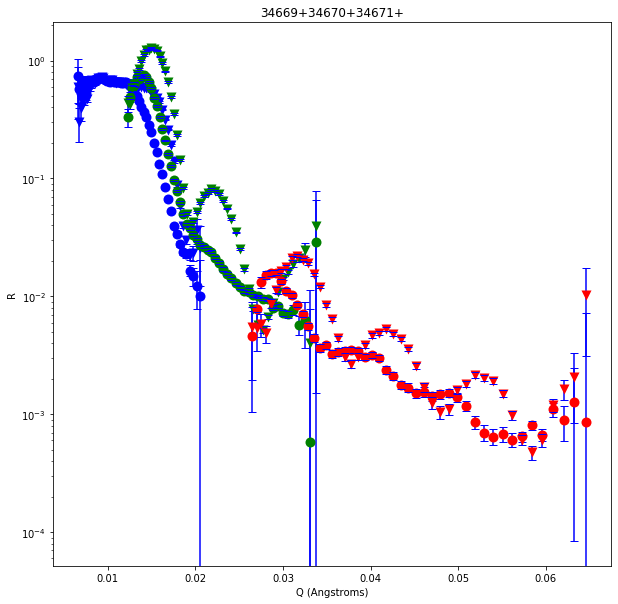

In [50]:
colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
symbols = cycle('ovovovovovovovovovovovovovov')
fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q (Angstroms)')
plt.ylabel('R')
plt.yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for i, col in zip(range(len(files)), colors):
    x = layer_dict[run_numbers[i]]
    for j, sym in zip(range(4), symbols):
        if active_spin_states[j]==1:
            q = x[:,0,j]
            h = x[:,1,j]
            e = x[:,2,j]
            ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
            ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
plt.show()


## Autoscale
User may need to re-execute this cell to reset the data from study in the following cells.

			Run #34669	Run #34670	Ratio
Integral sum: 		4.10E-03	7.85E-03	5.22E-01
Integral average: 	1.28E-04	1.36E-04	9.43E-01
Weighted average: 	5.76E-05	6.11E-05	9.44E-01
			Run #34670	Run #34671	Ratio
Integral sum: 		1.84E-04	1.85E-04	9.95E-01
Integral average: 	1.04E-05	1.56E-05	6.69E-01
Weighted average: 	5.09E-06	7.29E-06	6.98E-01
Ratio factors:  [0.94392896 0.6592242 ]


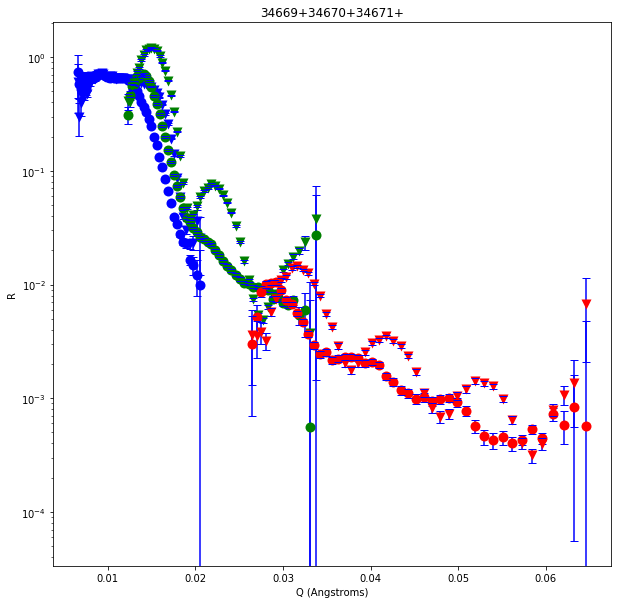

In [51]:
scaled = copy.deepcopy(layer_dict)

idx = np.argwhere(active_spin_states) # there is only one of up or dw
idx = int(idx[0])
# calculate the scale factors for each pair of files
s_factor = np.zeros(len(files)-1, dtype=np.float32)
for i in range(len(files)-1):
    qmax0 = -1e20
    qmin0 = 1e20
    x0 = scaled[run_numbers[i]]
    q0 = x0[:,0,idx]
    qmax0 = max([qmax0,np.max(q0)])
    qmin0 = min([qmin0,np.min(q0)])
    
    qmax1 = -1e20
    qmin1 = 1e20
    x1 = scaled[run_numbers[i+1]]
    q1 = x1[:,0,idx]
    qmax1 = max([qmax1,np.max(q1)])
    qmin1 = min([qmin1,np.min(q1)])
    
    over0 = np.argwhere(q0 >= qmin1)
    over1 = np.argwhere(q1 <= qmax0)
    over0 = over0[:,0]
    over1 = over1[:,0]
    
    n0 = len(over0)
    dx0 = np.zeros(n0,dtype=np.float32)
    for j in range(n0-1):
        dx0[j] = (q0[over0[j]+1]-q0[over0[j]-1])/2
    dx0[n0-1] = dx0[n0-2]
    
    n1 = len(over1)
    dx1 = np.zeros(n1,dtype=np.float32)
    for j in range(n1-1):
        dx1[j+1] = (q1[over1[j+1]+1]-q1[over1[j+1]-1])/2
    dx1[0] = dx1[1]
    
    if active_spin_states[0]==1 & active_spin_states[1]==1:     # use both up and dw   
        g0 = np.append(x0[over0,1,0],x0[over0,1,1])*np.append(dx0,dx0) # concatonate both spin states
        h0 = np.append(x0[over0,2,0],x0[over0,2,1])*np.append(dx0,dx0)
        f0 = (x0[over0,1,0]+x0[over0,1,1])*dx0
        e0 = (x0[over0,2,0]+x0[over0,2,1])*dx0
        g1 = np.append(x1[over1,1,0],x1[over1,1,1])*np.append(dx1,dx1)
        h1 = np.append(x1[over1,2,0],x1[over1,2,1])*np.append(dx1,dx1)
        f1 = (x1[over1,1,0]+x1[over1,1,1])*dx0
        e1 = (x1[over1,2,0]+x1[over1,2,1])*dx0
    else:
        g0 = x0[over0,1,idx]*dx0 # identical to case below cause no states to concatonate, reqd for transparency
        h0 = x0[over0,2,idx]*dx0
        f0 = x0[over0,1,idx]*dx0
        e0 = x0[over0,2,idx]*dx0
        g1 = x1[over1,1,idx]*dx1
        h1 = x1[over1,2,idx]*dx1
        f1 = x1[over1,1,idx]*dx1
        e1 = x1[over1,2,idx]*dx1
    a0 = np.sum(f0)
    b0 = np.average(f0,weights=1/e0)
    c0 = np.average(g0,weights=1/h0)
    a1 = np.sum(f1)
    b1 = np.average(f1,weights=1/e1)
    c1 = np.average(g1,weights=1/h1)
#    s_factor[i] = np.sum(a0/a1) #apply to file1 to scale to file0, sums only
#    s_factor[i] = np.sum(b0/b1) #apply to file1 to scale to file0, weighted aveage of sums
    s_factor[i] = np.sum(c0/c1) #apply to file1 to scale to file0, weighted average of each distribution
    print('\t\t\tRun #%s\tRun #%s\tRatio'%(run_numbers[i],run_numbers[i+1]))
    print('Integral sum: \t\t%.2E\t%.2E\t%.2E'%(a0,a1,np.sum(a0/a1)))
    print('Integral average: \t%.2E\t%.2E\t%.2E'%(b0,b1,np.sum(b0/b1)))
    print('Weighted average: \t%.2E\t%.2E\t%.2E'%(c0,c1,np.sum(c0/c1)))
# the nth s_factor is the product of it and the ones before.
for i in range(len(files)-2,0,-1):
    for j in range(i-1,-1,-1):
        s_factor[i] = s_factor[i]*s_factor[j]
print('Ratio factors: ',s_factor)
# apply scale
for i in range(1,len(files)):
    x = scaled[run_numbers[i]]
    for j in range(4):
        x[:,1,j] = x[:,1,j] * s_factor[i-1]
        x[:,2,j] = x[:,2,j] * s_factor[i-1]    
    
colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
symbols = cycle('ovovovovovovovovovovovovovov')
fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q (Angstroms)')
plt.ylabel('R')
plt.yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for i, col in zip(range(len(files)), colors):
    x = scaled[run_numbers[i]]
    for j, sym in zip(range(4), symbols):
        if active_spin_states[j]==1:
            q = x[:,0,j]
            h = x[:,1,j]
            e = x[:,2,j]
            ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
            ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
plt.show()

# Finally make a working copy of scaled
working = copy.deepcopy(scaled)

## Choose ROI for each file
USER INPUT NEEDED
    1) The following two blocks are user intensive. Requires iteration and occasional resetting using the prevous block.
    2) Choose Q-region to display
    3) Choose Q-values to exclude (these should be number of points on tail and leading edges for file pair)
    4) Repeat as appropriate

In [52]:
if batch_toggle != True:
    qzmin, qzmax = 0.005, 0.02 # user choice this tailors the plot range

    colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    symbols = cycle('ovovovovovovovovovovovovovov')
    fig, ax = plt.subplots(figsize = (10,10))
    plt.xlabel('Q (Angstroms)')
    plt.ylabel('R')
    plt.yscale('log')
    plt.xlim(qzmin,qzmax)
    title=''
    for i in range(len(files)):
        print('Run Number: %s %s'%(i,run_numbers[i]))
        title = title+run_numbers[i]+'+'
    plt.title(title)
    for i, col in zip(range(len(files)), colors):
        x = working[run_numbers[i]]
        for j, sym in zip(range(4), symbols):
            if active_spin_states[j]==1:
                q = x[:,0,j]
                h = x[:,1,j]
                e = x[:,2,j]
                ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
                ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
    plt.show()



## Test cut and scaling
USER INPUT NEEDED
    1) User input required for number of points to cut on the tail and front ends of file pair
    2) Will auto-scale
    3) If ok move on to next pair, if not, then reset effort with the Autoscale block.
    4) Record your work

In [53]:
if batch_toggle != True:
    run0 = run_numbers[0] # USER INPUT
    run1 = run_numbers[1] # USER INPUT
    ncut0 = 6 # USER INPUT
    ncut1 = 6 # USER INPUT
# cut tail of first file
    xlen = len(working[run0])
    for i in range(ncut0):
        xlen = len(working[run0])
        working[run0] = np.delete(working[run0],xlen-1,0)
# cut front of second file
    for i in range(ncut1):
        working[run1] = np.delete(working[run1],0,0)

    idx = np.argwhere(active_spin_states) # there is only one of up or dw
    idx = int(idx[0])
# calculate the scale factors for each pair of files
    s_factor = np.zeros(len(files)-1, dtype=np.float32)
    for i in range(len(files)-1):
        qmax0 = -1e20
        qmin0 = 1e20
        x0 = working[run_numbers[i]]
        q0 = x0[:,0,idx]
        qmax0 = max([qmax0,np.max(q0)])
        qmin0 = min([qmin0,np.min(q0)])
    
        qmax1 = -1e20
        qmin1 = 1e20
        x1 = working[run_numbers[i+1]]
        q1 = x1[:,0,idx]
        qmax1 = max([qmax1,np.max(q1)])
        qmin1 = min([qmin1,np.min(q1)])
    
        over0 = np.argwhere(q0 >= qmin1)
        over1 = np.argwhere(q1 <= qmax0)
        over0 = over0[:,0]
        over1 = over1[:,0]
    
        n0 = len(over0)
        dx0 = np.zeros(n0,dtype=np.float32)
        for j in range(n0-1):
            dx0[j] = (q0[over0[j]+1]-q0[over0[j]-1])/2
        dx0[n0-1] = dx0[n0-2]
    
        n1 = len(over1)
        dx1 = np.zeros(n1,dtype=np.float32)
        for j in range(n1-1):
            dx1[j+1] = (q1[over1[j+1]+1]-q1[over1[j+1]-1])/2
        dx1[0] = dx1[1]
    
        if active_spin_states[0]==1 & active_spin_states[1]==1:     # use both up and dw   
            g0 = np.append(x0[over0,1,0],x0[over0,1,1])*np.append(dx0,dx0) # concatonate both spin states
            h0 = np.append(x0[over0,2,0],x0[over0,2,1])*np.append(dx0,dx0)
            f0 = (x0[over0,1,0]+x0[over0,1,1])*dx0
            e0 = (x0[over0,2,0]+x0[over0,2,1])*dx0
            g1 = np.append(x1[over1,1,0],x1[over1,1,1])*np.append(dx1,dx1)
            h1 = np.append(x1[over1,2,0],x1[over1,2,1])*np.append(dx1,dx1)
            f1 = (x1[over1,1,0]+x1[over1,1,1])*dx0
            e1 = (x1[over1,2,0]+x1[over1,2,1])*dx0
        else:
            g0 = x0[over0,1,idx]*dx0 # identical to case below cause no states to concatonate, reqd for transparency
            h0 = x0[over0,2,idx]*dx0
            f0 = x0[over0,1,idx]*dx0
            e0 = x0[over0,2,idx]*dx0
            g1 = x1[over1,1,idx]*dx1
            h1 = x1[over1,2,idx]*dx1
            f1 = x1[over1,1,idx]*dx1
            e1 = x1[over1,2,idx]*dx1
        a0 = np.sum(f0)
        b0 = np.average(f0,weights=1/e0)
        c0 = np.average(g0,weights=1/h0)
        a1 = np.sum(f1)
        b1 = np.average(f1,weights=1/e1)
        c1 = np.average(g1,weights=1/h1)
#    s_factor[i] = np.sum(a0/a1) #apply to file1 to scale to file0, sums only
#    s_factor[i] = np.sum(b0/b1) #apply to file1 to scale to file0, weighted aveage of sums
        s_factor[i] = np.sum(c0/c1) #apply to file1 to scale to file0, weighted average of each distribution
        print('\t\t\tRun #%s\tRun #%s\tRatio'%(run_numbers[i],run_numbers[i+1]))
        print('Integral sum: \t\t%.2E\t%.2E\t%.2E'%(a0,a1,np.sum(a0/a1)))
        print('Integral average: \t%.2E\t%.2E\t%.2E'%(b0,b1,np.sum(b0/b1)))
        print('Weighted average: \t%.2E\t%.2E\t%.2E'%(c0,c1,np.sum(c0/c1)))
# the nth s_factor is the product of it and the ones before.
    for i in range(len(files)-2,0,-1):
        for j in range(i-1,-1,-1):
            s_factor[i] = s_factor[i]*s_factor[j]
    print('Ratio factors: ',s_factor)
# apply scale
    for i in range(1,len(files)):
        x = working[run_numbers[i]]
        for j in range(4):
            x[:,1,j] = x[:,1,j] * s_factor[i-1]
            x[:,2,j] = x[:,2,j] * s_factor[i-1]    
    
    colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    symbols = cycle('ovovovovovovovovovovovovovov')
    fig, ax = plt.subplots(figsize = (10,10))
    plt.xlabel('Q (Angstroms)')
    plt.ylabel('R')
    plt.yscale('log')
    title=''
    for i in range(len(files)):
        title = title+run_numbers[i]+'+'
    plt.title(title)
    for i, col in zip(range(len(files)), colors):
        x = working[run_numbers[i]]
        for j, sym in zip(range(4), symbols):
            if active_spin_states[j]==1:
                q = x[:,0,j]
                h = x[:,1,j]
                e = x[:,2,j]
                ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
                ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
    plt.show()

## Exclude cut regions, autoscale and write files

			Run #34669	Run #34670	Ratio
Integral sum: 		4.27E-04	1.31E-03	3.27E-01
Integral average: 	7.98E-05	2.37E-04	3.36E-01
Weighted average: 	3.22E-05	8.94E-05	3.60E-01
			Run #34670	Run #34671	Ratio
Integral sum: 		2.50E-05	2.30E-05	1.09E+00
Integral average: 	1.24E-05	1.15E-05	1.08E+00
Weighted average: 	5.94E-06	5.74E-06	1.03E+00
Ratio factors:  [0.35953277 0.37200013]


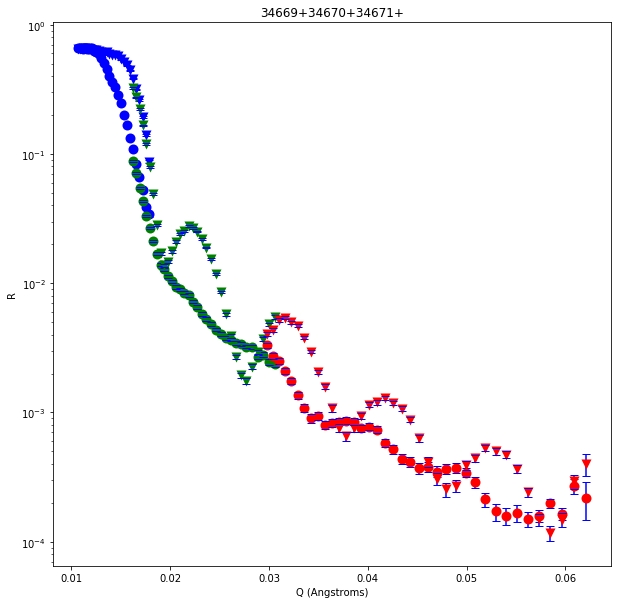

In [54]:
for j in range(len(files)):
    ncut0, ncut1 = big_cut[j]
# cut tail
    xlen = len(scaled[run_numbers[j]])
    for i in range(ncut1):
        xlen = len(scaled[run_numbers[j]])
        scaled[run_numbers[j]] = np.delete(scaled[run_numbers[j]],xlen-1,0)
# cut front
    for i in range(ncut0):
        scaled[run_numbers[j]] = np.delete(scaled[run_numbers[j]],0,0)

#Autoscale
idx = np.argwhere(active_spin_states) # there is only one of up or dw
idx = int(idx[0])
# calculate the scale factors for each pair of files
s_factor = np.zeros(len(files)-1, dtype=np.float32)
for i in range(len(files)-1):
    qmax0 = -1e20
    qmin0 = 1e20
    x0 = scaled[run_numbers[i]]
    q0 = x0[:,0,idx]
    qmax0 = max([qmax0,np.max(q0)])
    qmin0 = min([qmin0,np.min(q0)])
    
    qmax1 = -1e20
    qmin1 = 1e20
    x1 = scaled[run_numbers[i+1]]
    q1 = x1[:,0,idx]
    qmax1 = max([qmax1,np.max(q1)])
    qmin1 = min([qmin1,np.min(q1)])
    
    over0 = np.argwhere(q0 >= qmin1)
    over1 = np.argwhere(q1 <= qmax0)
    over0 = over0[:,0]
    over1 = over1[:,0]
    
    n0 = len(over0)
    dx0 = np.zeros(n0,dtype=np.float32)
    for j in range(n0-1):
        dx0[j] = (q0[over0[j]+1]-q0[over0[j]-1])/2
    dx0[n0-1] = dx0[n0-2]
    
    n1 = len(over1)
    dx1 = np.zeros(n1,dtype=np.float32)
    for j in range(n1-1):
        dx1[j+1] = (q1[over1[j+1]+1]-q1[over1[j+1]-1])/2
    dx1[0] = dx1[1]
    
    if active_spin_states[0]==1 & active_spin_states[1]==1:     # use both up and dw   
        g0 = np.append(x0[over0,1,0],x0[over0,1,1])*np.append(dx0,dx0) # concatonate both spin states
        h0 = np.append(x0[over0,2,0],x0[over0,2,1])*np.append(dx0,dx0)
        f0 = (x0[over0,1,0]+x0[over0,1,1])*dx0
        e0 = (x0[over0,2,0]+x0[over0,2,1])*dx0
        g1 = np.append(x1[over1,1,0],x1[over1,1,1])*np.append(dx1,dx1)
        h1 = np.append(x1[over1,2,0],x1[over1,2,1])*np.append(dx1,dx1)
        f1 = (x1[over1,1,0]+x1[over1,1,1])*dx0
        e1 = (x1[over1,2,0]+x1[over1,2,1])*dx0
    else:
        g0 = x0[over0,1,idx]*dx0 # identical to case below cause no states to concatonate, reqd for transparency
        h0 = x0[over0,2,idx]*dx0
        f0 = x0[over0,1,idx]*dx0
        e0 = x0[over0,2,idx]*dx0
        g1 = x1[over1,1,idx]*dx1
        h1 = x1[over1,2,idx]*dx1
        f1 = x1[over1,1,idx]*dx1
        e1 = x1[over1,2,idx]*dx1
    a0 = np.sum(f0)
    b0 = np.average(f0,weights=1/e0)
    c0 = np.average(g0,weights=1/h0)
    a1 = np.sum(f1)
    b1 = np.average(f1,weights=1/e1)
    c1 = np.average(g1,weights=1/h1)
#    s_factor[i] = np.sum(a0/a1) #apply to file1 to scale to file0, sums only
#    s_factor[i] = np.sum(b0/b1) #apply to file1 to scale to file0, weighted aveage of sums
    s_factor[i] = np.sum(c0/c1) #apply to file1 to scale to file0, weighted average of each distribution
    print('\t\t\tRun #%s\tRun #%s\tRatio'%(run_numbers[i],run_numbers[i+1]))
    print('Integral sum: \t\t%.2E\t%.2E\t%.2E'%(a0,a1,np.sum(a0/a1)))
    print('Integral average: \t%.2E\t%.2E\t%.2E'%(b0,b1,np.sum(b0/b1)))
    print('Weighted average: \t%.2E\t%.2E\t%.2E'%(c0,c1,np.sum(c0/c1)))
# the nth s_factor is the product of it and the ones before.
for i in range(len(files)-2,0,-1):
    for j in range(i-1,-1,-1):
        s_factor[i] = s_factor[i]*s_factor[j]
print('Ratio factors: ',s_factor)
# apply scale
for i in range(1,len(files)):
    x = scaled[run_numbers[i]]
    for j in range(4):
        x[:,1,j] = x[:,1,j] * s_factor[i-1]
        x[:,2,j] = x[:,2,j] * s_factor[i-1]    
    
colors =  cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
symbols = cycle('ovovovovovovovovovovovovovov')
fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q (Angstroms)')
plt.ylabel('R')
plt.yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for i, col in zip(range(len(files)), colors):
    x = scaled[run_numbers[i]]
    for j, sym in zip(range(4), symbols):
        if active_spin_states[j]==1:
            q = x[:,0,j]
            h = x[:,1,j]
            e = x[:,2,j]
            ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
            ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
plt.show()


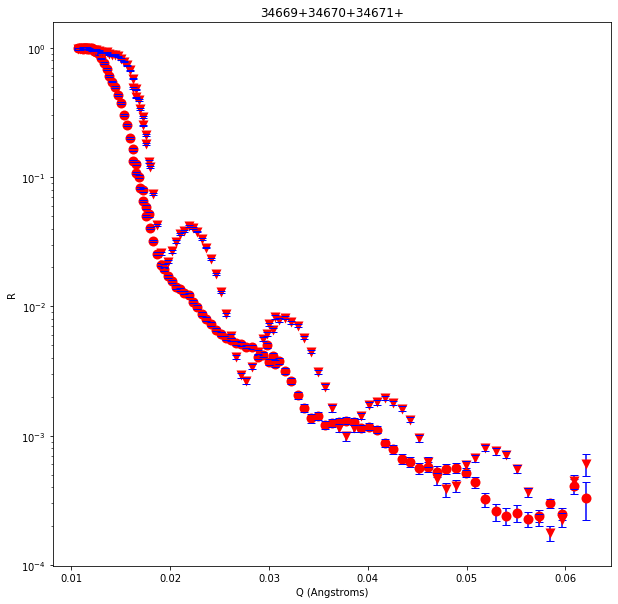

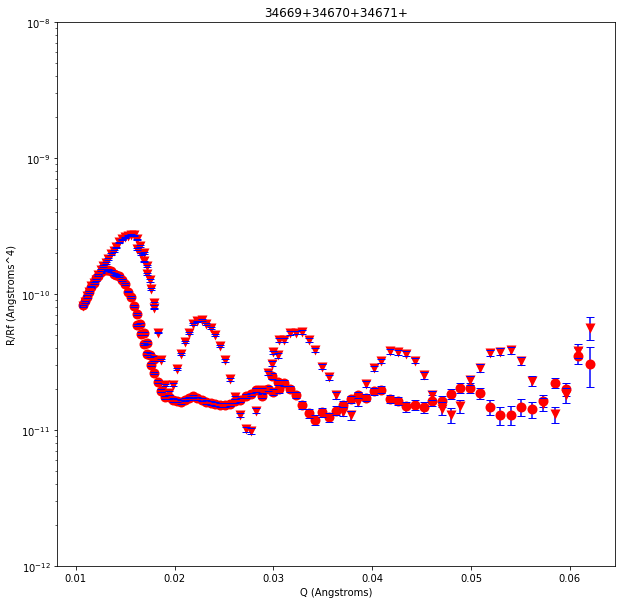

In [55]:
# find the maximum reflectivity
rmax = -1.
rmin = 1.e20
for j in range(len(files)):
    x = scaled[run_numbers[j]]
    rmax = np.max([rmax,np.max(x[:,1,:])])
    rmin = np.min([rmin,np.min(np.abs(x[:,1,0]))])
# use rmax to scale all files so that the max reflectivity is 1 and scale the errors.
# will replace -'ve values of R with rmin and assign error bar of 1 to them.

# write the individual scaled files
for j in range(len(files)):
    x = scaled[run_numbers[j]]
    x[:,1,:] = x[:,1,:]/rmax # this performs the scaling to the critical edge
    x[:,2,:] = x[:,2,:]/rmax
    if active_spin_states[0]==1:
        fault = np.argwhere(x[:,1,0]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,0] = rmin/rmax
        x[fault_idx,2,0] = 1./rmax        
        file_output = open(files[j]+'_red_pp.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,0],x[i,1,0],x[i,2,0],x[i,3,0])
            file_output.write(row)
        file_output.close()
    if active_spin_states[1]==1:
        fault = np.argwhere(x[:,1,1]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,1] = rmin/rmax
        x[fault_idx,2,1] = 1./rmax        
        file_output = open(files[j]+'_red_mm.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,1],x[i,1,1],x[i,2,1],x[i,3,1])
            file_output.write(row)
        file_output.close()
    if active_spin_states[2]==1:
        fault = np.argwhere(x[:,1,2]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,2] = rmin/rmax
        x[fault_idx,2,2] = 1./rmax        
        file_output = open(files[j]+'_red_mp.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,2],x[i,1,2],x[i,2,2],x[i,3,2])
            file_output.write(row)
        file_output.close()
    if active_spin_states[3]==1:
        fault = np.argwhere(x[:,1,3]<0)
        fault_idx = fault[:,0]
        x[fault_idx,1,3] = rmin/rmax
        x[fault_idx,2,3] = 1./rmax        
        file_output = open(files[j]+'_red_pm.out','w')
        for i in range(len(x)):
            row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(x[i,0,3],x[i,1,3],x[i,2,3],x[i,3,3])
            file_output.write(row)
        file_output.close()
    
# create the concatonated data set
x = scaled[run_numbers[0]]
s = copy.deepcopy(x)
for j in range(len(files)-1):
    s = np.append(s,scaled[run_numbers[j+1]],0)
idx = np.argsort(s[:,0,0]) # sort by ascending q
s_sort = s[idx]

fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q (Angstroms)')
plt.ylabel('R')
plt.yscale('log')
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for j, sym in zip(range(4), symbols):
    if active_spin_states[j]==1:
        q = s_sort[:,0,j]
        h = s_sort[:,1,j]
        e = s_sort[:,2,j]
        ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
        ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
plt.show()

fig, ax = plt.subplots(figsize = (10,10))
plt.xlabel('Q (Angstroms)')
plt.ylabel('R/Rf (Angstroms^4)')
plt.yscale('log')
plt.ylim(1e-12,1e-8)
title=''
for i in range(len(files)):
    title = title+run_numbers[i]+'+'
plt.title(title)
for j, sym in zip(range(4), symbols):
    if active_spin_states[j]==1:
        q = s_sort[:,0,j]
        h = s_sort[:,1,j]/(16*np.pi**2/q**4)
        e = s_sort[:,2,j]/(16*np.pi**2/q**4)
        ax.plot(q,h, linestyle='None', marker=sym, markerfacecolor=col, markeredgecolor='None', markersize=10)
        ax.errorbar(q,h,yerr=e,capsize=4,ls='None',ecolor='b')
plt.show()


# write the concatonated files
if active_spin_states[0]==1:
    file_output = open(directory_path+title+'_pp.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,0],s_sort[i,1,0],s_sort[i,2,0],s_sort[i,3,0])
        file_output.write(row)
    file_output.close()
if active_spin_states[1]==1:
    file_output = open(directory_path+title+'_mm.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,1],s_sort[i,1,1],s_sort[i,2,1],s_sort[i,3,1])
        file_output.write(row)
    file_output.close()
if active_spin_states[2]==1:
    file_output = open(directory_path+title+'_mp.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,2],s_sort[i,1,2],s_sort[i,2,2],s_sort[i,3,2])
        file_output.write(row)
    file_output.close()
if active_spin_states[3]==1:
    file_output = open(directory_path+title+'_pm.out','w')
    for i in range(len(s_sort)):
        row = '%.5E\t%.5E\t%.5E\t%.5E\n'%(s_sort[i,0,3],s_sort[i,1,3],s_sort[i,2,3],s_sort[i,3,3])
        file_output.write(row)
    file_output.close()

